# Clustering

Last access (y.m.d): 20.04.06  
Last update (y.m.d): 20.04.06   

This notebook will be used to cluster the daa in terms of basic tuning properties and sfMix metrics of interest. The data source will be jointList*, which contains vital tuning properties for each cell in our experiment. 

### Table of contents

- Initialize  
- Regression
- Clustering
    - kmeans
    - agglomerative
- tSNE

## Initialize

In [1]:
import numpy as np
import os
import helper_fcns as hf
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress

from sklearn.manifold import TSNE
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import pdb

import seaborn as sns
# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

In [150]:
# jointList_nm = 'jointList_V1full_200406.npy';
jointList_nm = 'jointList_200406.npy';

jointList = np.load('%s' % (jointList_nm))

## Regression

Let's start simple first. We can analyze tuning properties are correlated with one another, and which are correlated with the sfMix metrics we care about (for example, prefSF shift with contrast)

#### Unpack the core metrics

In [152]:
### NOTE: The following will be stored as log2 (ratios, frequency values)
# - f1f0 (ratio)
# - c50 (contrast viewed in log)
# - sfPref_basic (sf viewed in log2)
# - tfPref (tf viewed in log2)
# - mix_sfPref (sf measure)
# - mix_charFreq (sf measure)
# - gsf_data/mod (size in degrees)
# - mix_prefRadData (already in log2)
# - mix_psfModRat[Norm] (already in log2)

nCells = len(jointList);

c50_basic = np.nan * np.zeros((nCells, ))
c50_eff_basic = np.copy(c50_basic);

f1f0 = np.copy(c50_basic)

supr_data = np.copy(c50_basic)
supr_mod = np.copy(c50_basic)
gsf_data = np.copy(c50_basic)
gsf_mod = np.copy(c50_basic)

sfPref_basic = np.copy(c50_basic)
sfBW_basic = np.copy(c50_basic)

tfPref = np.copy(c50_basic)
tfBW = np.copy(c50_basic)

oriPref = np.copy(c50_basic)
oriBW = np.copy(c50_basic)
oriCV = np.copy(c50_basic)
oriDS = np.copy(c50_basic)

mix_sfPref = np.copy(c50_basic)
mix_c50 = np.copy(c50_basic)
mix_c50_eff = np.copy(c50_basic)
mix_bwHalf = np.copy(c50_basic)
mix_bw34 = np.copy(c50_basic)
mix_charFreq = np.copy(c50_basic)

mix_prefRatData = np.copy(c50_basic)
mix_bwHalfDiffData = np.copy(c50_basic)
mix_bw34DiffData = np.copy(c50_basic)

mix_psfModRat = np.copy(c50_basic)
mix_psfModRat_norm = np.copy(c50_basic)

for ind in np.arange(nCells):
    #########
    ### Basics (basic characterizations, f1f0)
    #########
    # f1/f0
    try:
        f1f0[ind] = np.log2(jointList[ind]['metrics']['f1f0_ratio']);
    except:
        pass
    # RF SIZE
    try: # suppression index from model fit (Cavanaugh '02, see hf.sizeTune for details)
        supr_data[ind] = jointList[ind]['basics']['rfsize']['suprInd_data']
    except:
        pass
    try: # suppression index from data (Cavanaugh '02, see hf.sizeTune for details)
        supr_mod[ind] = jointList[ind]['basics']['rfsize']['suprInd_model']
    except:
        pass
    try: # grating summation field from model fit (Cavanaugh '02, see hf.sizeTune for details)
        gsf_data[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_data'])
    except:
        pass
    try: # rating summation fieldfrom data (Cavanaugh '02, see hf.sizeTune for details)
        gsf_mod[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_model'])
    except:
        pass
    # RVC
    try: # get c50
        c50_basic[ind] = np.log2(jointList[ind]['basics']['rvc']['c50'])
        c50_eff_basic[ind] = np.log2(jointList[ind]['basics']['rvc']['c50_eval'])
    except:
        pass
    # TF
    try: # get prefTF
        tfPref[ind] = np.log2(jointList[ind]['basics']['tf']['tfPref'])
    except:
        pass
    try: # get tfBW
        tfBW[ind] = jointList[ind]['basics']['tf']['tfBW_oct']
    except:
        pass
    # Orientation
    try: # get oriPref
        oriPref[ind] = jointList[ind]['basics']['ori']['pref']
    except:
        pass
    try: # get oriBW
        oriBW[ind] = jointList[ind]['basics']['ori']['bw']
    except:
        pass
    try: # get oriCV
        oriCV[ind] = jointList[ind]['basics']['ori']['cv']
    except:
        pass
    try: # get DS
        oriDS[ind] = jointList[ind]['basics']['ori']['DS']
    except:
        pass
    # SF tuning (from the sf1* series, not as measured in the sfMix experiment)
    try: # get prefSf
        sfPref_basic[ind] = np.log2(jointList[ind]['basics']['sf']['sfPref'])
    except:
        pass
    try: # get sfbw
        sfBW_basic[ind] = jointList[ind]['basics']['sf']['sfBW_oct']
    except:
        pass

    
    #########
    ### sfMixture metrics
    #########
    try: # prefSf
        mix_sfPref[ind] = np.log2(jointList[ind]['metrics']['pSf'][0,-1]);
    except:
        pass
    try: # c50 at SF nearest to prefSF
        sf_vals = jointList[ind]['metadata']['stimVals'][2];
        if ~np.isnan(mix_sfPref[ind]):
            prefSfInd = np.argmin(np.square(np.power(2, mix_sfPref[ind]) - sf_vals));
        else:
            # what sf_val is closest to the "center of mass" for single grating, high con?
            prefSfInd = np.argmin(np.square(jointList[ind]['metrics']['sfCom'][0, -1] - sf_vals));
        mix_c50[ind] = np.log2(jointList[ind]['metrics']['c50'][0, prefSfInd]);
        mix_c50_eff[ind] = np.log2(jointList[ind]['metrics']['c50_eval'][0, prefSfInd]);
    except:
        pass
    try: # sfBW 1/2
        mix_bwHalf[ind] = jointList[ind]['metrics']['bwHalf'][0,-1];
    except:
        pass
    try: # sfBW 3/4
        mix_bw34[ind] = jointList[ind]['metrics']['bw34'][0,-1];
    except:
        pass
    try: # characteristic frequency
        mix_charFreq[ind] = np.log2(jointList[ind]['metrics']['dog_charFreq'][0,-1]);
    except:
        pass
    try:
        dispInd = 0; # evaluate this for single gratings
        # prefSf ratio 1:0.33 in data
        mix_prefRatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 2];
        # bwHalf ratio 1:0.33 in data
        mix_bwHalfDiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 0];
        # bw34 ratio 1:0.33 in data
        mix_bw34DiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 1];
    except:
        pass
    try: # prefSfModRat
        dispInd = 0; # evaluate this for single gratings
        # we fit a model to the prefSF as a function of contrast - the log2 ratio of that model at the highest/lowest valid contrast
        mix_psfModRat[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 0];
        # the same ratio normalized by the log contrast ratio of highest/lowest
        mix_psfModRat_norm[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 1];
    except:
        pass


#### Unpack the sfMix metrics

In [153]:
supr_index = [jointList[x]['superpos']['supr_index'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]
corr_err = [jointList[x]['superpos']['corr_derivWithErr'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]
corr_errNorm = [jointList[x]['superpos']['corr_derivWithErrNorm'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]
errs_auc = [jointList[x]['superpos']['errs_auc'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]

## Clustering

### Kmeans

In [177]:
data_labels = ('f1f0', 'supr_mod', 'c50_eff', 'prefSf')
data_subset = np.vstack((f1f0, supr_mod, mix_c50_eff, mix_sfPref))
to_remove = np.unique(np.where(np.isnan(data_subset))[-1])

to_keep = np.setxor1d(np.arange(data_subset.shape[-1]), to_remove);

data_subset = data_subset[:, to_keep].transpose();

print('We started with %d cells; after removing NaN, now %d' % (f1f0.shape[0], data_subset.shape[0]));

We started with 123 cells; after removing NaN, now 79


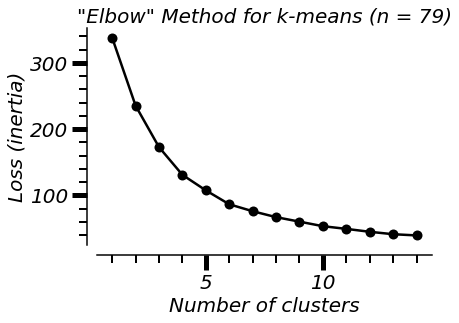

In [178]:
kmn_err = [];
kmn_ids = [];

k_nums = np.arange(1, 15)

for k_i in k_nums:
    kmeans = KMeans(n_clusters=k_i, init='k-means++', max_iter=300, n_init=10, random_state=None).fit(data_subset)
    kmn_err.append(kmeans.inertia_)
    kmn_ids.append(kmeans.labels_)
    
plt.plot(k_nums, kmn_err, 'k-o', markersize=10)
plt.title('"Elbow" Method for k-means (n = %d)' % data_subset.shape[0])
plt.xlabel('Number of clusters')
plt.ylabel('Loss (inertia)')
sns.despine(offset=10)

#### Now, let z-score the data and re-do the k-means
Why? These clustering algorithms (and low-dimensional projecting) will be poor if the space is highly asymmetric. i.e., it should be as smooth and uniform as possible

In [179]:
z_scored = ss.zscore(data_subset, axis=0)

# print('We started with %d cells; after removing NaN, now %d' % (f1f0.shape[0], data_subset.shape[0]));

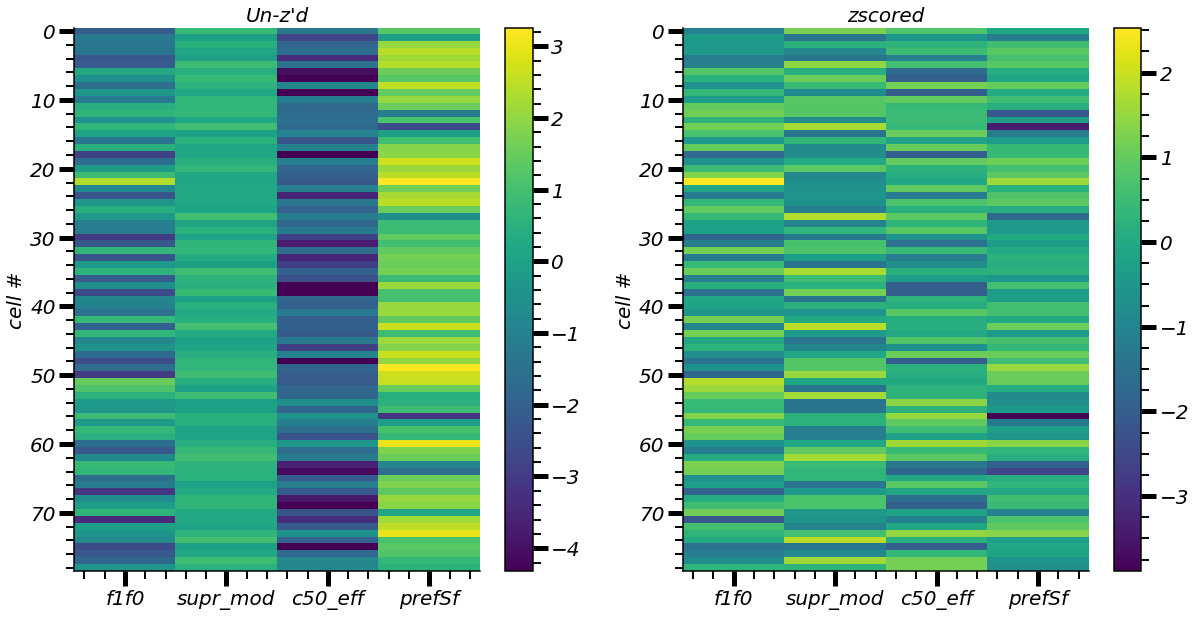

In [180]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

oh = ax[0].imshow(data_subset, aspect='auto');
ax[0].set_ylabel('cell #')
ax[0].set_title('Un-z\'d')
f.colorbar(oh, ax=ax[0])
plt.sca(ax[0])
plt.xticks(range(len(data_labels)), data_labels);

ah = ax[1].imshow(z_scored, aspect='auto');
ax[1].set_ylabel('cell #')
ax[1].set_title('zscored')
f.colorbar(ah, ax=ax[1])
plt.sca(ax[1])
plt.xticks(range(len(data_labels)), data_labels);

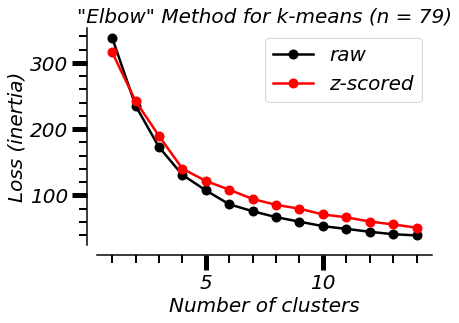

In [181]:
kmn_err_z = [];
kmn_ids_z = [];

k_nums = np.arange(1, 15)

for k_i in k_nums:
    kmeans = KMeans(n_clusters=k_i, init='k-means++', max_iter=300, n_init=10, random_state=None).fit(z_scored)
    kmn_err_z.append(kmeans.inertia_)
    kmn_ids_z.append(kmeans.labels_)
    
plt.plot(k_nums, kmn_err, 'k-o', markersize=10, label='raw')
plt.plot(k_nums, kmn_err_z, 'r-o', markersize=10, label='z-scored')
plt.title('"Elbow" Method for k-means (n = %d)' % data_subset.shape[0])
plt.xlabel('Number of clusters')
plt.ylabel('Loss (inertia)')
plt.legend()
sns.despine(offset=10)

### Agglomerative

In [182]:
### First, agglomerative clustering (meaning we build up clusters from the bottom up) 
# without specifying the number of clusters to see how the data shape up hierarchically

# default linkage is Ward, which requires euclidian distance (affinity) metric
agg = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(z_scored) 

In [183]:
# from: https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    n_labs = len(np.unique(labels))
    
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]),
                 color=plt.cm.nipy_spectral(labels[i] / n_labs),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

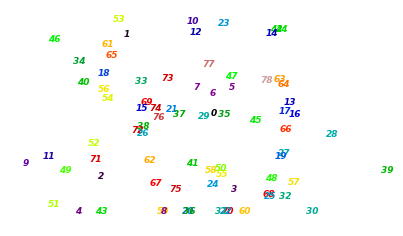

In [184]:
plot_clustering(data_subset, agg.labels_)

In [185]:
# copied from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

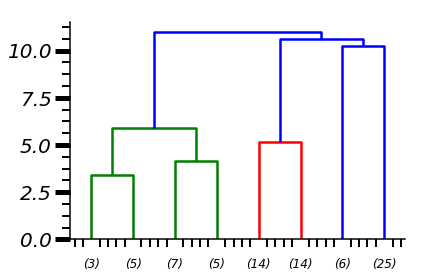

In [186]:
plot_dendrogram(agg, truncate_mode='level', p=2)

In [330]:
### Now, we specify the number of clusters

# default linkage is Ward, which requires euclidian distance (affinity) metric
n_clust = 5;
agg = AgglomerativeClustering(n_clusters=n_clust).fit(z_scored) 

## tSNE for plotting

In [340]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=6000)
tsne_results = tsne.fit_transform(z_scored)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 79 samples in 0.000s...
[t-SNE] Computed neighbors for 79 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 79 / 79
[t-SNE] Mean sigma: 1.082936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.734825


/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[t-SNE] KL divergence after 2550 iterations: 0.302006


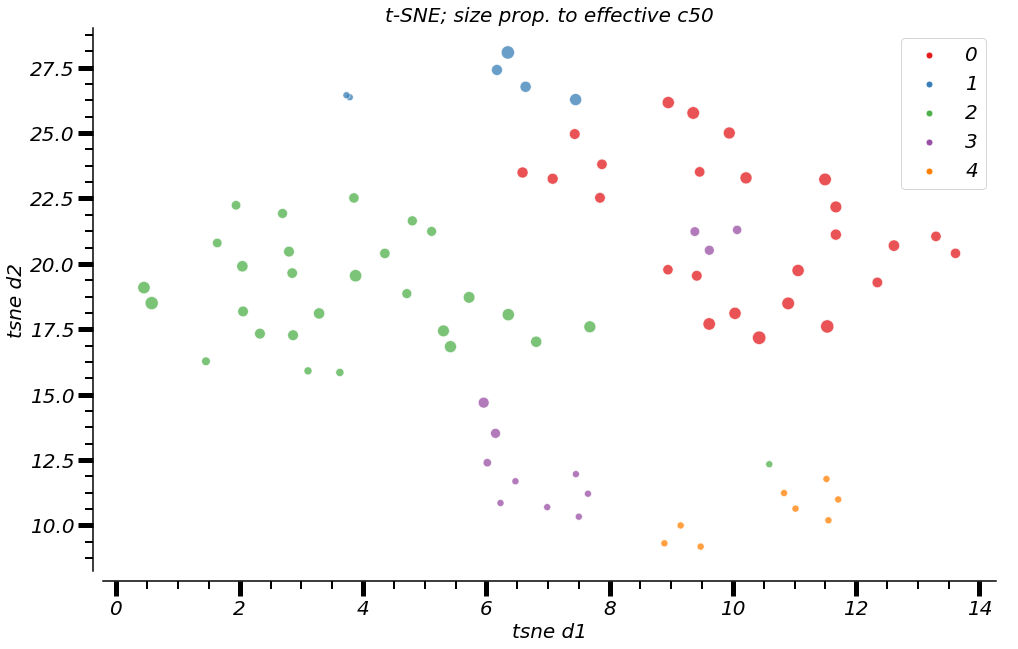

In [344]:
d1 = tsne_results[:,0]
d2 = tsne_results[:,1]
plt.figure(figsize=(16,10))

clr = agg.labels_;
n_clust = len(np.unique(clr))
# clr = kmn_ids[4];

szs = np.maximum(50, 100 + np.multiply(50, ss.zscore(mix_c50_eff[to_keep])));
plt.title('t-SNE; size prop. to effective c50')

# szs = np.maximum(50, 100 + np.multiply(50, ss.zscore(mix_sfPref[to_keep])));
#plt.title('t-SNE; size prop. to prefSf')


sns.scatterplot(
    x=d1, y=d2,
    hue=clr,
    palette=sns.color_palette("Set1", n_clust),
    alpha=0.75,
    s=szs
)

plt.legend()
# plt.legend(labels=['clust %d' %x for x in np.arange(n_clust)])
plt.xlabel('tsne d1');
plt.ylabel('tsne d2');
sns.despine(offset=10)

Now, what are the real indices (in jointList) for these cells, and there directory/cellnum:

In [360]:
lbls = agg.labels_;
for i in np.unique(lbls):
    which_inds = np.where(lbls == i);
    joint_inds = to_keep[which_inds];
    base_dir = [jointList[i]['metadata']['fullPath'].split('/')[-3] for i in joint_inds]
    cell_num = [jointList[i]['metadata']['cellNum'] for i in joint_inds]
    print('cluster %d:' % i)
    [print('\t %s/%d' % (x,y)) for x, y in zip(base_dir, cell_num)]

cluster 0:
	 V1_orig/1
	 V1_orig/3
	 V1_orig/6
	 V1_orig/9
	 V1_orig/11
	 V1_orig/12
	 V1_orig/22
	 V1_orig/23
	 V1_orig/32
	 V1_orig/35
	 V1_orig/39
	 V1_orig/44
	 V1_orig/47
	 V1_orig/51
	 V1_orig/54
	 V1_orig/55
	 V1/3
	 V1/8
	 V1/14
	 V1/17
	 V1/22
	 V1/50
	 V1/51
	 V1/54
	 V1/55
cluster 1:
	 V1_orig/13
	 V1_orig/15
	 V1_orig/30
	 V1/6
	 V1/23
	 V1/31
cluster 2:
	 V1_orig/2
	 V1_orig/4
	 V1_orig/10
	 V1_orig/14
	 V1_orig/16
	 V1_orig/18
	 V1_orig/24
	 V1_orig/25
	 V1_orig/26
	 V1_orig/28
	 V1_orig/29
	 V1_orig/31
	 V1_orig/38
	 V1_orig/43
	 V1_orig/45
	 V1_orig/46
	 V1_orig/48
	 V1_orig/49
	 V1_orig/50
	 V1_orig/56
	 V1/1
	 V1/4
	 V1/5
	 V1/11
	 V1/12
	 V1/35
	 V1/43
	 V1/47
cluster 3:
	 V1_orig/5
	 V1_orig/17
	 V1_orig/20
	 V1_orig/27
	 V1_orig/33
	 V1_orig/36
	 V1_orig/40
	 V1/34
	 V1/40
	 V1/46
	 V1/52
	 V1/53
cluster 4:
	 V1_orig/7
	 V1_orig/8
	 V1_orig/34
	 V1_orig/41
	 V1_orig/42
	 V1_orig/52
	 V1/41
	 V1/42
